## Welcome to exercise 03
앞서 배운 것들을 바탕으로 실습을 해봅시다
1) RNN을 LSTM으로 바꿔봅시다 <br>
2) RNN을 ``01_nn_tutorial``을 따라 단계적으로 리팩토링 해봅시다<br>
3) learning curve, embedding을 ``02_Tensorboard``를 따라 tensorboard와 연결해봅시다

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## Data Loading

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
import unicodedata
import string

In [4]:
all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)

In [5]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

In [6]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

In [7]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

## data to Tensor

In [8]:
import torch

In [9]:
# find index of letter
def letterToIndex(letter):
    return all_letters.find(letter)

# 이름(word, line)을 <line_length x 1 x n_letters>로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [10]:
lineToTensor('Jones').shape # 5 -> len('Jones'), 1(batch), 56(len(all_letters))

torch.Size([5, 1, 56])

## Network

In [11]:
from torch import nn

### RNN 

$$ h_t = W_{i2h}(h_{t-1}\mathbin\Vert x_{t-1}) $$
$$ y_t = softmax(W_{i2o}(h_{t-1}\mathbin\Vert x_{t-1})) $$
$$ _{(\mathbin\Vert \space denotes \space concatenation)} $$

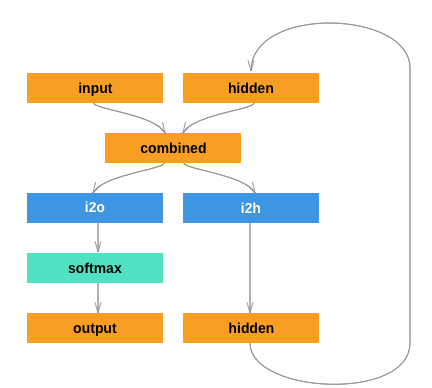

### LSTM 

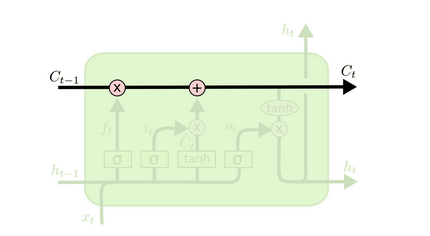

$$ f_t = \sigma(W_f[h_{t-1},x_t]+b_f) $$
$$ i_t = \sigma(W_i[h_{t-1},x_t]+b_i) $$
$$ \tilde{C_t} = tanh(W_c[h_{t-1},x_t]+b_i) $$
$$ C_t = \sigma(f_t * C_{t-1} + i_t * \tilde{C_t}) $$
$$ o_t = \sigma(W_o[h_{t-1}, x_t]+b_o) $$
$$ h_t = tanh(C_t) * o_t $$

In [12]:
torch.Tensor([1]).name

In [20]:
def print_shape(obj):
    print('{} shape : {}'.format(obj.name, obj.shape))

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2c = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2y = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        forget_rate = self.i2f(combined)
        forget_rate = self.sigmoid(forget_rate)
        input_rate = self.i2i(combined)
        input_rate = self.sigmoid(input_rate)
        cell_tilda = self.i2c(combined)
        cell_tilda = self.tanh(cell_tilda)
        cell = forget_rate * cell + input_rate * cell_tilda 
        output_rate = self.i2o(combined)
        output_rate = self.sigmoid(output_rate)
        hidden = self.tanh(cell) * output_rate
        output = self.h2y(hidden)
        output = self.softmax(output)
        return output, hidden, cell
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)        

## model instance test

In [34]:
n_hidden = 128
rnn = LSTM(n_letters, n_hidden, n_categories)
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden) # initial hidden statate as zero vector
cell = torch.zeros(1, n_hidden) # initial hidden statate as zero vector
output, next_hidden, next_cell = rnn(input[0], hidden, cell)
output

tensor([[-2.8610, -2.9629, -2.8970, -2.9229, -2.8939, -2.9446, -2.8100, -2.9372,
         -2.9250, -2.8469, -2.9484, -2.8216, -2.8268, -2.9534, -2.9286, -2.8896,
         -2.8157, -2.8640]], grad_fn=<LogSoftmaxBackward>)

## prepare for train

In [35]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 6)


In [36]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Masson
category = Italian / line = Moschella
category = Czech / line = Holub
category = Portuguese / line = Moreno
category = Portuguese / line = Souza
category = Chinese / line = Chu
category = Scottish / line = Bell
category = Arabic / line = Shalhoub
category = Arabic / line = Morcos
category = French / line = Lemaire


## train network 

In [37]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [44]:
def train(category_tensor, line_tensor):
    # 한 배치에 대한 train 코드
    hidden = rnn.initHidden() # hidden layer 초기화
    cell = rnn.initHidden() # cell layer 초기화

    
    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden, cell = rnn(line_tensor[i], hidden, cell) 
        # 글자마다 output은 나오는데 for문에서는 hidden만 사용되고
    
    # for 문이 끝나면 output이 평가됨
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss

In [45]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 19s) 2.9410 Lao / Polish ✗ (Chinese)
10000 10% (0m 39s) 2.7672 Rudawski / Polish ✓
15000 15% (1m 3s) 2.8675 Tahan / French ✗ (Arabic)
20000 20% (1m 26s) 2.8790 Mendes / Greek ✗ (Portuguese)
25000 25% (1m 49s) 2.8636 Yep / Irish ✗ (Chinese)
30000 30% (2m 14s) 2.9568 Rocha / Japanese ✗ (Spanish)
35000 35% (2m 35s) 2.6700 Panek / Irish ✗ (Czech)
40000 40% (2m 54s) 2.6219 Venn / Korean ✗ (Dutch)
45000 45% (3m 16s) 1.9740 Szwedko / Italian ✗ (Polish)
50000 50% (3m 35s) 4.4617 Gravari / Italian ✗ (Greek)
55000 55% (3m 54s) 2.0767 Sinclair / French ✗ (Scottish)
60000 60% (4m 14s) 2.2268 Aust / Arabic ✗ (German)
65000 65% (4m 34s) 1.7985 Quaranta / Japanese ✗ (Italian)
70000 70% (4m 53s) 2.0407 Scott / German ✗ (Scottish)
75000 75% (5m 13s) 2.6343 Kattan / Scottish ✗ (Arabic)
80000 80% (5m 36s) 1.2663 Parent / French ✓
85000 85% (5m 58s) 0.9031 Nie / Chinese ✓
90000 90% (6m 20s) 0.8152 Reilly / Irish ✓
95000 95% (6m 40s) 1.6587 Rietveld / English ✗ (Dutch)
100000 100% (7m 1s) 3.238

## learning curve

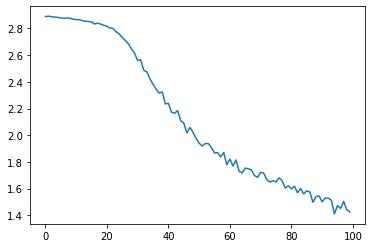

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## evaluation ( metrics )  

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


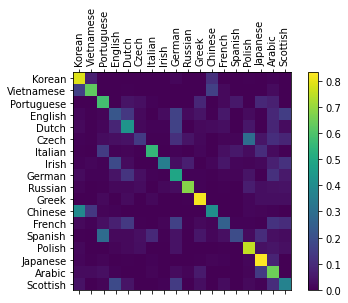

In [49]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    cell = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()